In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [3]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
df['date'] = pd.to_datetime('01 -' + df['year'].astype(str) + '-' + df['month'].astype(str))
df.set_index('date', inplace=True)
df.head()   

,year,month,passengers
date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


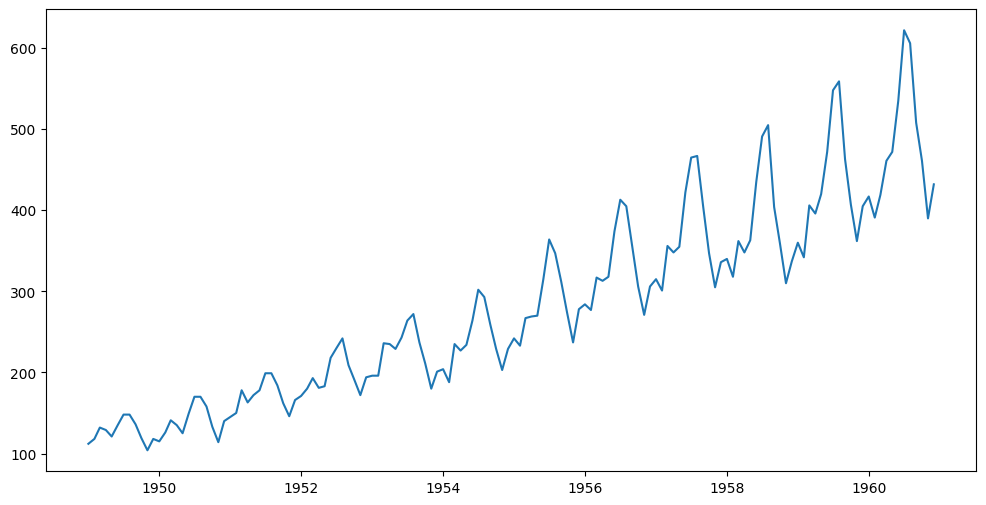

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['passengers'])

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
adfTest = adfuller(df['passengers'])

In [8]:
adfTest

(0.8153688792060482,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [9]:
adf_stats = pd.Series(adfTest[0:4], index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
adf_stats

ADF Test Statistic       0.815369
P-Value                  0.991880
# Lags Used             13.000000
# Observations Used    130.000000
dtype: float64

In [10]:
def test_stationarity(dataframe, timeseries):
    #Determing rolling statistics
    rolmean = dataframe[timeseries].rolling(window=12).mean()
    rolstd = dataframe[timeseries].rolling(window=12).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe[timeseries], label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    #Perform Dickey-Fuller test:
    adfTest = adfuller(dataframe[timeseries])
    adf_stats = pd.Series(adfTest[0:4], index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])

    for key, value in adfTest[4].items():
        adf_stats['Critical Value (%s)'%key] = value
    print(adf_stats)

ADF Test Statistic        0.815369
P-Value                   0.991880
# Lags Used              13.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


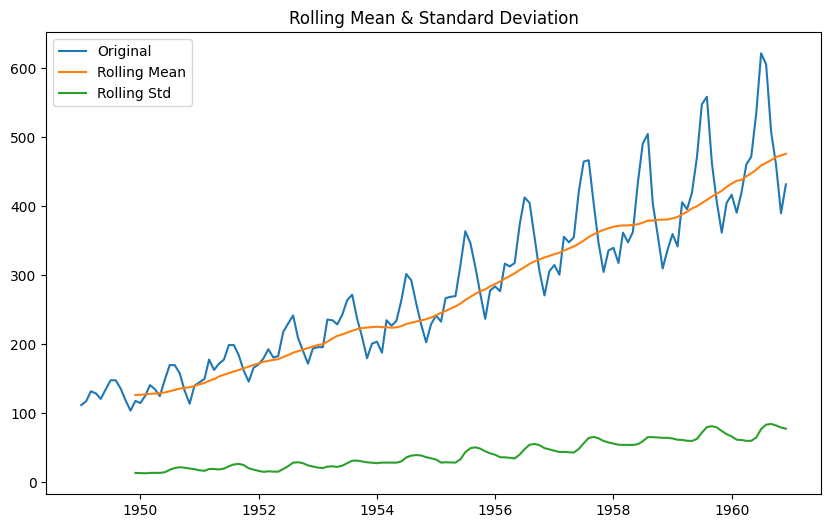

In [11]:
test_stationarity(df, 'passengers')

In [12]:
df.head()

,year,month,passengers
date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


In [13]:
df.drop(['year', 'month'], axis=1, inplace=True)

ADF Test Statistic        0.815369
P-Value                   0.991880
# Lags Used              13.000000
# Observations Used     130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


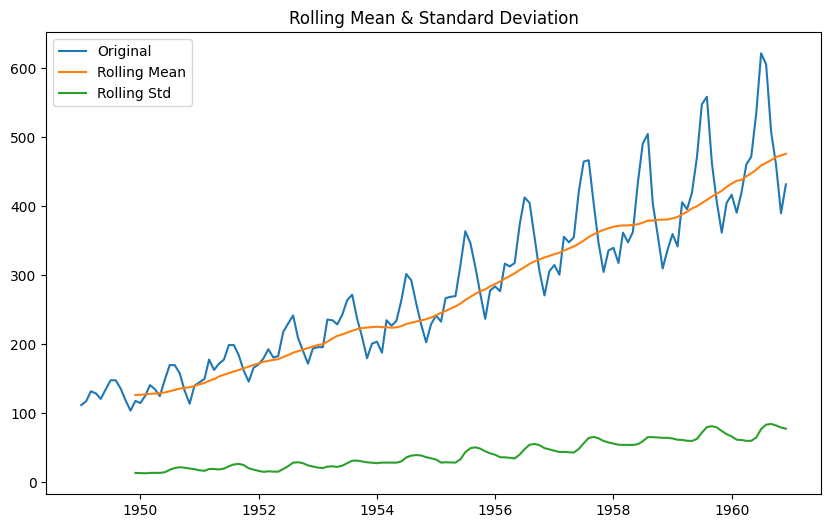

In [14]:
test_stationarity(df, 'passengers')

In [15]:
df.tail()

,passengers
date,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [16]:
df['shift'] = df['passengers'].shift(1)
df['shiftDiff1'] = df['passengers'] - df['shift']
df['shiftDiff2'] = df['shiftDiff1'] - df['shiftDiff1'].shift(1)


In [17]:
df.head()   

,passengers,shift,shiftDiff1,shiftDiff2
date,,,,
1949-01-01,112,NaN,NaN,NaN
1949-02-01,118,112.0,6.0,NaN
1949-03-01,132,118.0,14.0,8.0
1949-04-01,129,132.0,-3.0,-17.0
1949-05-01,121,129.0,-8.0,-5.0


ADF Test Statistic       -2.833426
P-Value                   0.053655
# Lags Used              12.000000
# Observations Used     129.000000
Critical Value (1%)      -3.482088
Critical Value (5%)      -2.884219
Critical Value (10%)     -2.578864
dtype: float64


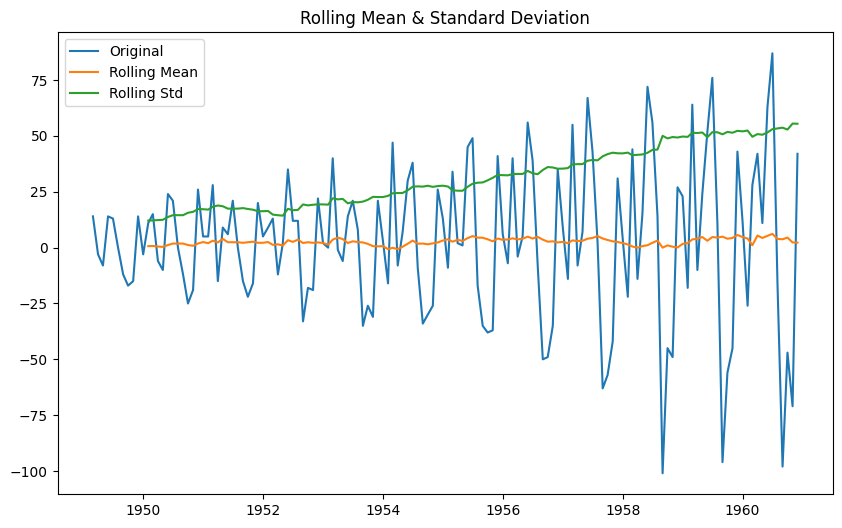

In [18]:
test_stationarity(df.dropna(), 'shiftDiff1')

ADF Test Statistic     -1.638423e+01
P-Value                 2.732892e-29
# Lags Used             1.100000e+01
# Observations Used     1.300000e+02
Critical Value (1%)    -3.481682e+00
Critical Value (5%)    -2.884042e+00
Critical Value (10%)   -2.578770e+00
dtype: float64


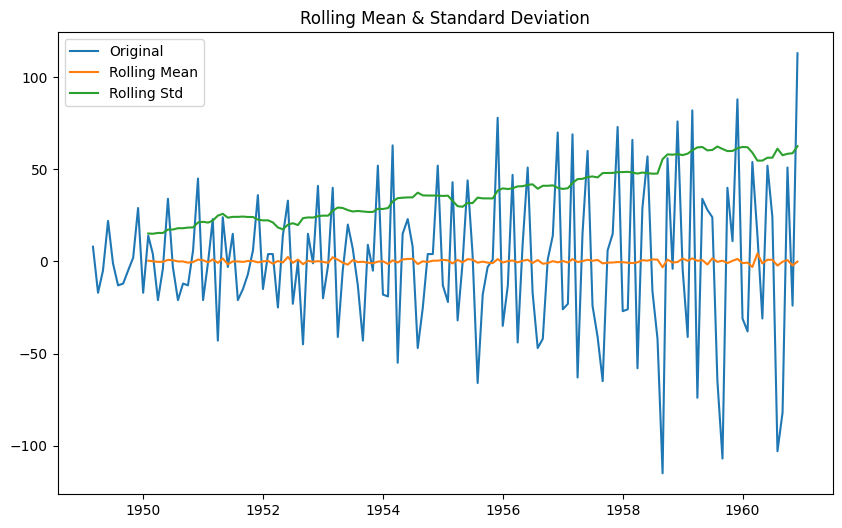

In [19]:
test_stationarity(df.dropna(), 'shiftDiff2')

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

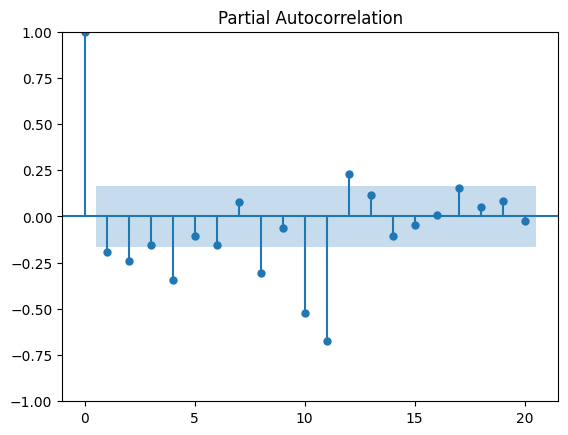

In [21]:
plot_pacf(df['shiftDiff2'].dropna(), lags=20);

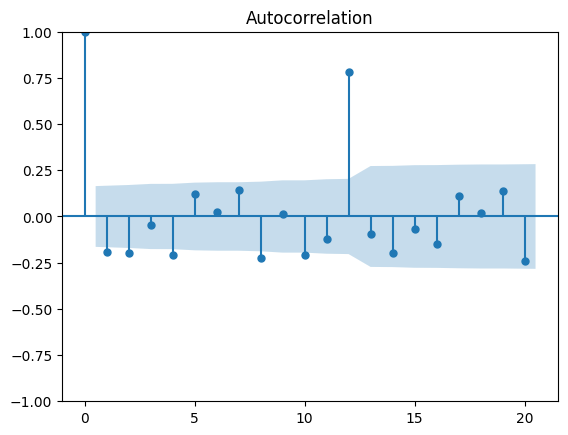

In [22]:
plot_acf(df['shiftDiff2'].dropna(), lags=20);

In [23]:
train = df[:round(len(df)*0.7)]
test = df[round(len(df)*0.7):]

In [24]:
model = ARIMA(train['passengers'], order=(1, 2, 2))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])
df['ARIMApred'] = prediction 

c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


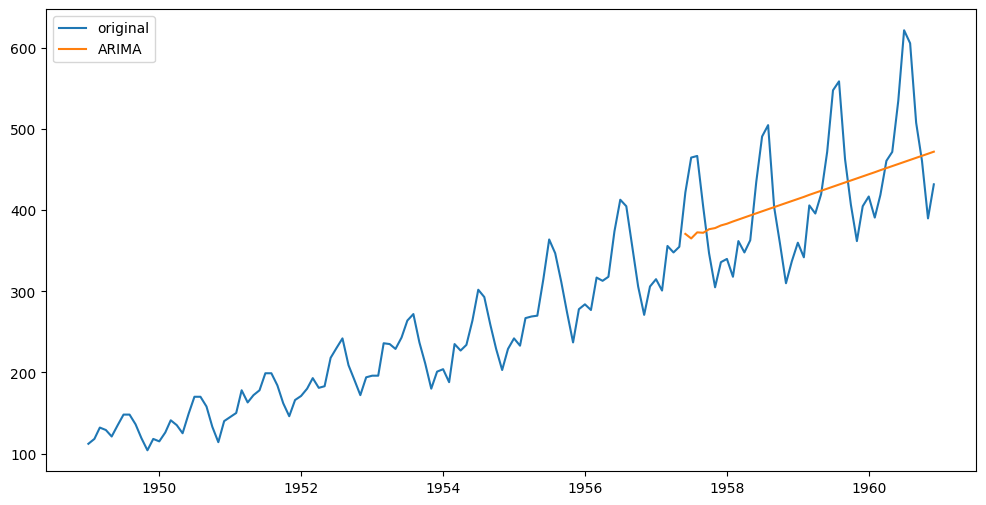

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(df['passengers'], label='original')
plt.plot(df['ARIMApred'], label='ARIMA')
plt.legend(loc='best')

In [26]:
df['diff12'] = df['passengers'].diff(12) 

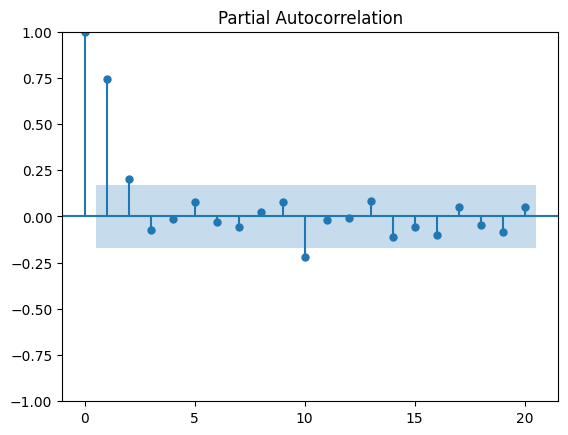

In [27]:
plot_pacf(df['diff12'].dropna(), lags=20);


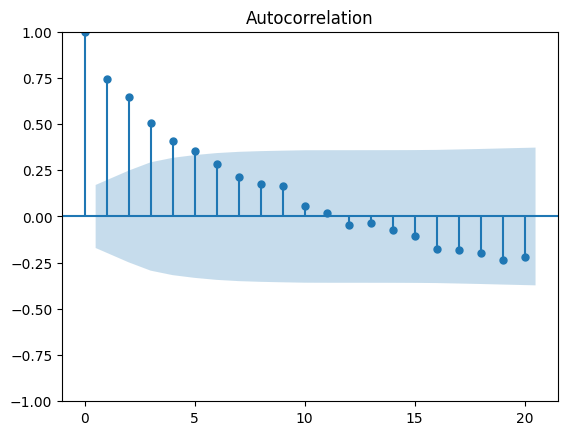

In [28]:
plot_acf(df['diff12'].dropna(), lags=20);

In [56]:
model2 = SARIMAX(train['passengers'], order=(1, 2, 2), seasonal_order=(2, 2, 3, 12))
model2_fit = model2.fit()
prediction2 = model2_fit.predict(start=test.index[0], end=test.index[-1])
df['SARIMAXpred'] = prediction2

c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


c:\Users\Ali\anaconda3\envs\timeseries_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


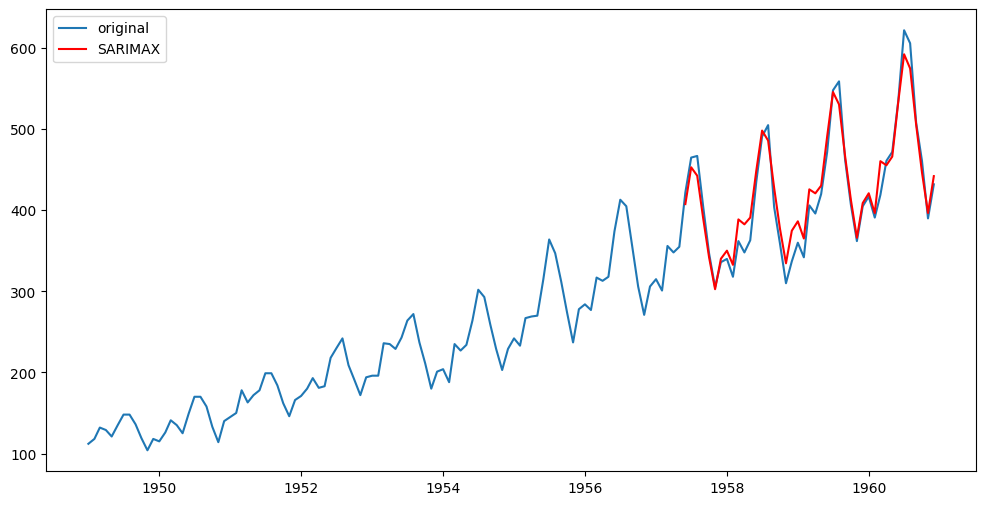

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(df['passengers'], label='original')
plt.plot(df['SARIMAXpred'], label='SARIMAX', color = 'red')
plt.legend(loc='best')


In [58]:
from sklearn.metrics import mean_squared_error

In [59]:
np.sqrt(mean_squared_error(test['passengers'], df['SARIMAXpred'][test.index[0]:]))

18.922499978845796

In [60]:
np.sqrt(mean_squared_error(test['passengers'], df['ARIMApred'][test.index[0]:]))

67.86810307413562

In [61]:
forecast_df = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01', freq='MS'),columns=['dates']).set_index('dates')

In [62]:
forecast_df['prediction'] = model2_fit.predict(start='1961-01-01', end='1962-12-01')

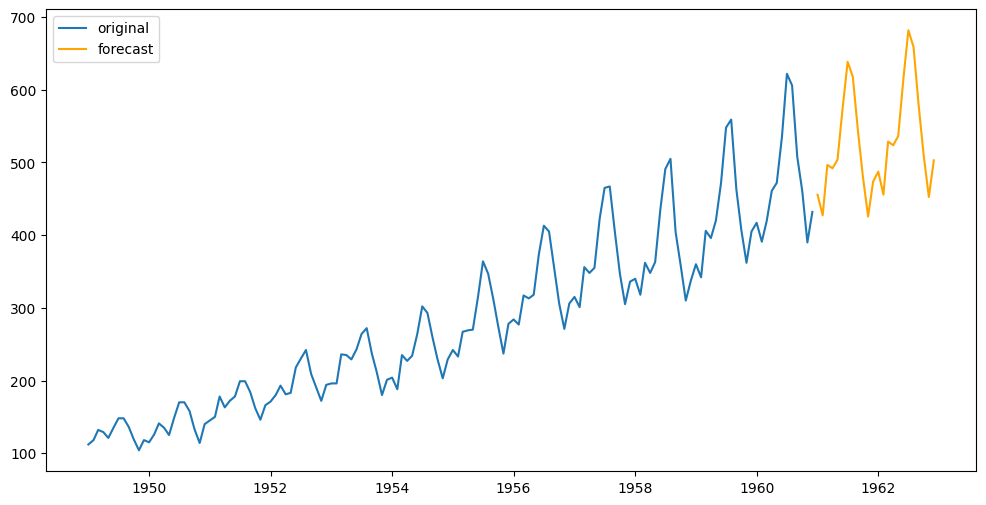

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(df['passengers'], label='original')
# plt.plot(df['SARIMAXpred'], label='SARIMAX', color = 'red')
plt.plot(forecast_df['prediction'], label='forecast', color = 'orange')
plt.legend(loc='best')
